In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.stats import multivariate_normal
import gpflow
import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf
import pickle
import sys
sys.path.insert(1, "../ipsc_gp_clustering")
from splitgpm import SplitGPM
from utils import gen_gsea_df
import gpflow.training.monitor as mon
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics.cluster import adjusted_rand_score
import seaborn as sns

## Evaluating the impact of stratification by batch vs by individual

### Neuronal lineage

In [2]:
C=9
G=5000
T=5
K1=3
K2=10
N=C*T

In [3]:
X = np.loadtxt("../data/neur.X.batchind.txt")
Y = np.loadtxt("../data/neur.Y.batchind.txt")

In [4]:
def normalize(X):
    return X / X.sum(1)[:, None]

In [5]:
gpflow.reset_default_graph_and_session()
name = 'test'
minibatch_size = 500
W1_init = normalize(np.random.random(size=(C, K1)))
W2_init = normalize(np.random.random(size=(G, K2)))

In [6]:
with gpflow.defer_build():
    kernel = mk.SharedIndependentMok(gpflow.kernels.RBF(1, active_dims=[0]), K1 * K2)
    Z = np.linspace(0, 1, T)[:, None].astype(np.float64)
    feature = gpflow.features.InducingPoints(Z)
    feature = mf.SharedIndependentMof(feature)
    model = SplitGPM(X, Y, np.log(W1_init + 1e-5), np.log(W2_init + 1e-5), kernel, gpflow.likelihoods.Gaussian(), feat=feature, minibatch_size=minibatch_size, name=name)
model.compile()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Tensor("test/add_6:0", shape=(?, 30), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 30), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)


In [7]:
model.W1.set_trainable(True)  # learn cell assignments
model.W2.set_trainable(True)  # learn gene assignments
model.feature.set_trainable(True)  # move inducing points
model.kern.set_trainable(True)  # learn kernel parameters
model.likelihood.set_trainable(True)  # learn likelihood parameters

In [8]:
adam = gpflow.train.AdamOptimizer(0.005)
adam.minimize(model, maxiter=10000)

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


In [11]:
Xnew = np.linspace(0, 1, 100)[:, None]
mu, var = model.predict_f(Xnew)

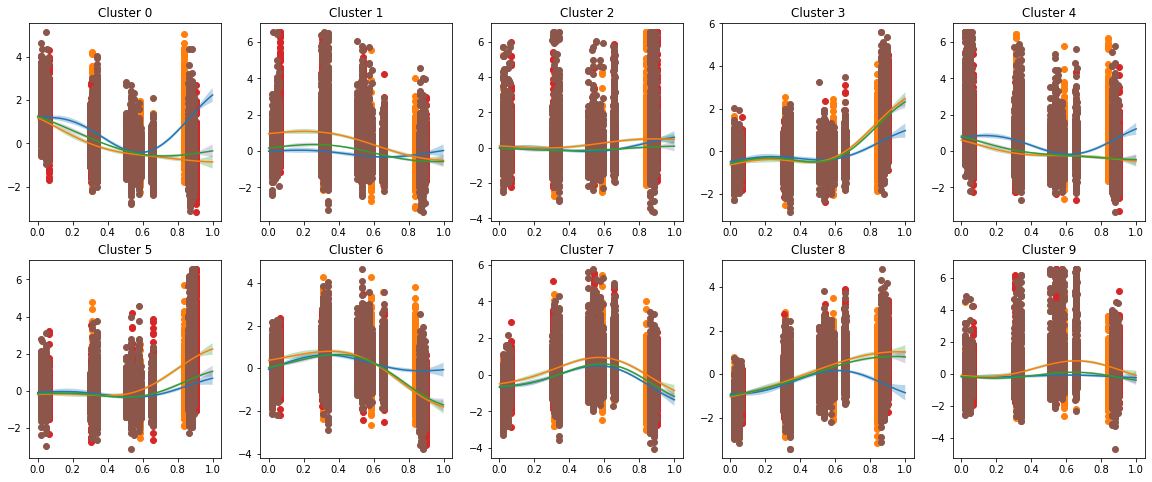

In [12]:
fig, ax = plt.subplots(2,5, figsize=(20,8))

mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T

a1 = model.W1.value.argmax(1)[X[:, 1].astype(int)]
a2 = model.W2.value.argmax(1)[X[:, 2].astype(int)]
for k in range(K1):
    for l in range(K2):
        ax[int(l/5), l%5].plot(Xnew, mu[:, l, k])
        ax[int(l/5), l%5].set_title("Cluster %d" % l)
        ax[int(l/5), l%5].fill_between(
            Xnew.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)
        
        assigned_points = np.logical_and(a1 == k, a2 == l)
        ax[int(l/5), l%5].scatter(X[assigned_points, 0], Y[assigned_points])

In [13]:
cell_line_assign = model.W1.value.argmax(1)
cell_line_assign

array([2, 2, 2, 2, 2, 0, 1, 2, 2])

Check how consistent these assignments are

In [15]:
C=9
G=5000
T=5
K1=3
K2=10
N=C*T

In [16]:
cell_line_assign = np.zeros([9,10], dtype=int)

In [20]:
for i in range(10):
    gpflow.reset_default_graph_and_session()
    name = 'test'
    minibatch_size = 500
    W1_init = normalize(np.random.random(size=(C, K1)))
    W2_init = normalize(np.random.random(size=(G, K2)))
    with gpflow.defer_build():
        kernel = mk.SharedIndependentMok(gpflow.kernels.RBF(1, active_dims=[0]), K1 * K2)
        Z = np.linspace(0, 1, T)[:, None].astype(np.float64)
        feature = gpflow.features.InducingPoints(Z)
        feature = mf.SharedIndependentMof(feature)
        model = SplitGPM(X, Y, np.log(W1_init + 1e-5), np.log(W2_init + 1e-5), kernel, gpflow.likelihoods.Gaussian(), feat=feature, minibatch_size=minibatch_size, name=name)
    model.compile()
    model.W1.set_trainable(True)  # learn cell assignments
    model.W2.set_trainable(True)  # learn gene assignments
    model.feature.set_trainable(True)  # move inducing points
    model.kern.set_trainable(True)  # learn kernel parameters
    model.likelihood.set_trainable(True)  # learn likelihood parameters
    adam = gpflow.train.AdamOptimizer(0.005)
    adam.minimize(model, maxiter=10000)
    cell_line_assign[:,i] = model.W1.value.argmax(1)

Tensor("test/add_6:0", shape=(?, 30), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 30), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 30), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 30), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 30), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 30), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 30), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 30), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 30), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 30), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", sh

In [21]:
agreement = np.zeros([C,C], dtype=int)

In [29]:
for i in range(C):
    for j in range(C):
        agreement[i,j] = sum(cell_line_assign[i,:] == cell_line_assign[j,:])
        agreement[j,i] = agreement[i,j]

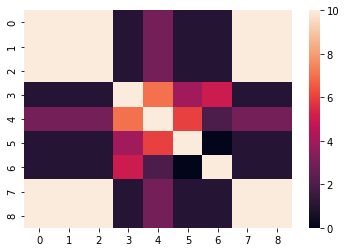

In [31]:
sns.heatmap(agreement)

In [34]:
numcells = np.array([  47.,   75.,  658., 2314., 1262., 1730.,   70.,  128.,  396.,
         16.,   53.,  116.,   11.,   27.,    6.,   44.,   32.,   85.,
         36.,   67.,  224.,   19.,   65.,   11.,   68.,   39.,  114.,
       2412., 1549., 1821.,  260.,  365.,  132., 2127.,  665.,  814.,
        170.,  114.,  136.,    9.,    5.,    6.,   73.,   20.,   72.])

In [38]:
np.reshape(numcells, [5,3,3], 'C').sum(0)

array([[2681., 1858., 2955.],
       [2613., 1724., 1885.],
       [2382.,  884., 1481.]])